In [1]:
import pandas as pd

# Đường dẫn file gốc
input_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\vnexpress_news_full.csv"
# Đường dẫn file xuất ra
output_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\sample_news_10rows.csv"
# Đọc 10 dòng đầu tiên

df = pd.read_csv(input_file, nrows=10)
# Lưu lại thành file mới
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Đã lưu 10 dòng đầu tiên vào:", output_file)


Đã lưu 10 dòng đầu tiên vào: D:\ViNewsRec\vietnamese_news_dataset\data\sample_news_10rows.csv


In [2]:
import pandas as pd

# Đường dẫn file gốc
input_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\vnexpress_news_full_auto_entities.csv"
# Đường dẫn file xuất ra
output_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\sample_news_entities_10rows.csv"
# Đọc 10 dòng đầu tiên

df = pd.read_csv(input_file, nrows=10)
# Lưu lại thành file mới
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Đã lưu 10 dòng đầu tiên vào:", output_file)

Đã lưu 10 dòng đầu tiên vào: D:\ViNewsRec\vietnamese_news_dataset\data\sample_news_entities_10rows.csv


In [3]:
import pandas as pd

# Đường dẫn file gốc
input_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\user_behavior.csv"
# Đường dẫn file xuất ra
output_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\sample_users_behavior_syn_10rows.csv"
# Đọc 10 dòng đầu tiên

df = pd.read_csv(input_file, nrows=10)
# Lưu lại thành file mới
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Đã lưu 10 dòng đầu tiên vào:", output_file)

Đã lưu 10 dòng đầu tiên vào: D:\ViNewsRec\vietnamese_news_dataset\data\sample_users_behavior_syn_10rows.csv


In [1]:
import pandas as pd

# Đường dẫn file gốc
input_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\behaviors.tsv"
# Đường dẫn file xuất ra
output_file = r"D:\ViNewsRec\vietnamese_news_dataset\data\behaviors_10rows.tsv"
# Đọc 10 dòng đầu tiên

df = pd.read_csv(input_file, nrows=10)
# Lưu lại thành file mới
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Đã lưu 10 dòng đầu tiên vào:", output_file)

Đã lưu 10 dòng đầu tiên vào: D:\ViNewsRec\vietnamese_news_dataset\data\behaviors_10rows.tsv


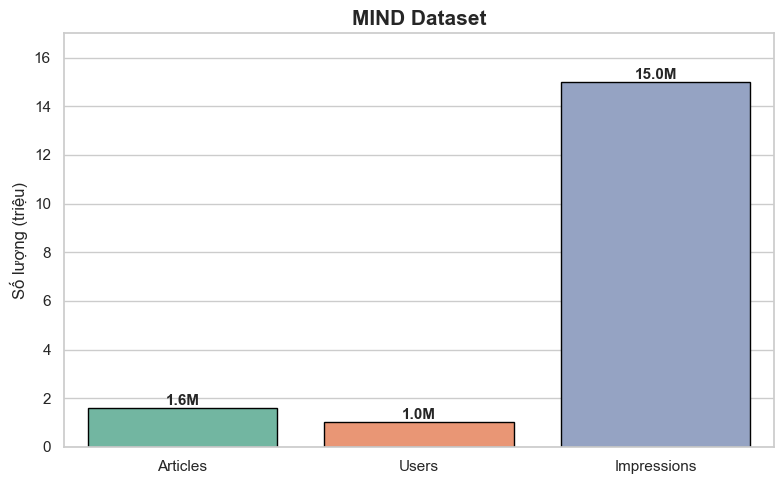

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dữ liệu
data = {
    'Category': ['Articles', 'Users', 'Impressions'],
    'Value': [1.6, 1.0, 15.0]  # Đơn vị: triệu (M)
}

df = pd.DataFrame(data)

# Thiết lập style cho seaborn
sns.set(style="whitegrid", palette="pastel")

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df, x='Category', y='Value', hue='Category', dodge=False, palette='Set2', edgecolor='black')

# Thêm nhãn giá trị trên cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}M',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Tiêu đề và nhãn
plt.title('MIND Dataset', fontsize=15, fontweight='bold')
plt.ylabel('Số lượng (triệu)')
plt.xlabel('')
plt.ylim(0, max(df['Value']) + 2)

# Tùy chọn làm gọn legend
plt.legend([],[], frameon=False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
import json
import warnings
from transformers import AutoTokenizer, AutoModel
import torch
import xgboost as xgb
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

# Đường dẫn đến files dữ liệu (thay đổi nếu cần)
NEWS_FILE = r'D:\ViNewsRec\vietnamese_news_dataset\data\news.tsv'
BEHAVIORS_FILE = r'D:\ViNewsRec\vietnamese_news_dataset\data\behaviors.tsv'

# Bước 1: Đọc dữ liệu
print("Đang đọc dữ liệu...")
news_df = pd.read_csv(NEWS_FILE, sep='\t', encoding='utf-8')
behaviors_df = pd.read_csv(BEHAVIORS_FILE, sep='\t', encoding='utf-8')

# Bước 2: Chuẩn bị text cho embeddings (title + abstract)
news_df['text'] = news_df['title'].fillna('') + ' ' + news_df['abstract'].fillna('')
news_df['news_id'] = news_df['news_id'].astype(str)  # Đảm bảo news_id là string

# Tạo mapping từ news_id đến index trong news_df
news_id_to_idx = {news_id: idx for idx, news_id in enumerate(news_df['news_id'])}

# Load PhoBERT cho embeddings (cải thiện representation cho tiếng Việt)
print("Đang tải PhoBERT...")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")

def get_embedding(text):
    if pd.isna(text) or not text.strip():
        return np.zeros(768)  # PhoBERT dim=768
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Mean pooling

# Áp dụng embeddings cho news
news_df['embedding'] = news_df['text'].apply(get_embedding)
news_vectors = np.vstack(news_df['embedding'])  # Shape: (num_news, 768)
print(f"Embeddings shape: {news_vectors.shape}")

# Bước 3: Thêm features phụ (category one-hot và entity counts)
# One-hot encode category
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_vectors = enc.fit_transform(news_df[['category']])  # Shape:(num_news, num_cats)

# Parse entities và count (từ title_entities và abstract_entities)
def count_entities(ents_str, label):
    if pd.isna(ents_str):
        return 0
    try:
        ents = json.loads(ents_str)
        return sum(1 for e in ents if e.get('Label') == label)
    except:
        return 0

for label in ['PER', 'ORG', 'LOC', 'MISC']:
    news_df[f'title_{label}_count'] = news_df['title_entities'].apply(lambda x: count_entities(x, label))
    news_df[f'abs_{label}_count'] = news_df['abstract_entities'].apply(lambda x: count_entities(x, label))

ents_cols = [f'title_{label}_count' for label in ['PER', 'ORG', 'LOC', 'MISC']] + \
            [f'abs_{label}_count' for label in ['PER', 'ORG', 'LOC', 'MISC']]
ents_vectors = news_df[ents_cols].values  # Shape: (num_news, 8)

# Tính tổng số entity cho mỗi tin
news_df['total_entities'] = news_df[ents_cols].sum(axis=1)

# Kết hợp news_vectors = embeddings + cat + ents
news_vectors = np.hstack([news_vectors, cat_vectors, ents_vectors])
print(f"News vectors full shape: {news_vectors.shape}")

# Bước 4: Expand behaviors thành các cặp (user, news, label) và tính features
features = []
labels = []

for _, row in behaviors_df.iterrows():
    user_id = row['user_id']
    history_str = row['history']
    impressions_str = row['impressions']
    
    # Lấy history news_ids
    if history_str == 'N/A' or pd.isna(history_str):
        history_ids = []
    else:
        history_ids = history_str.split()
    
    # Tính user_embedding: average của history vectors (embeddings + cat + ents)
    if history_ids:
        history_idxs = [news_id_to_idx.get(nid) for nid in history_ids if nid in news_id_to_idx]
        if history_idxs:
            history_vecs = news_vectors[history_idxs]
            user_emb = np.mean(history_vecs, axis=0)  # Average full vector
        else:
            user_emb = np.zeros(news_vectors.shape[1])
    else:
        user_emb = np.zeros(news_vectors.shape[1])
    
    # Lấy impressions
    impressions = impressions_str.split()
    for imp in impressions:
        nid, label = imp.split('-')
        label = int(label)
        
        if nid not in news_id_to_idx:
            continue
        
        news_idx = news_id_to_idx[nid]
        news_emb = news_vectors[news_idx]  # Full news vector
        
        # Tính cosine similarity giữa user_emb và news_emb
        sim = cosine_similarity([user_emb], [news_emb])[0][0]
        
        # Feature vec: user_emb + news_emb + sim
        feature_vec = np.hstack([user_emb, news_emb, [sim]])
        
        features.append(feature_vec)
        labels.append(label)

# Chuyển thành arrays
X = np.array(features)
y = np.array(labels)
print(f"Dataset shape: {X.shape}, Labels: {y.shape} (positive rate: {y.mean():.2f})")

# Bước 5: Oversampling với SMOTE để cân bằng
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Bước 6: Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Bước 7: Huấn luyện XGBoost (model phức tạp hơn)
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8)
model.fit(X_train, y_train)

# Bước 8: Dự đoán và đánh giá
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nKết quả đánh giá (Click Prediction - Improved):")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

# Bước 9: Thống kê bổ sung
print("\nThống kê bổ sung:")

# 9.1: Phần trăm tin theo chủ đề
category_percent = news_df['category'].value_counts(normalize=True) * 100
print("\nPhần trăm tin theo chủ đề:")
for cat, pct in category_percent.items():
    print(f"{cat}: {pct:.2f}%")

# 9.2: Tỷ lệ click vs no-click 
click_ratio = y.mean() * 100
no_click_ratio = 100 - click_ratio
print(f"\nTỷ lệ click: {click_ratio:.2f}%")
print(f"Tỷ lệ no-click: {no_click_ratio:.2f}%")

# 9.3: Số entity trung bình mỗi tin
avg_entities = news_df['total_entities'].mean()
print(f"\nSố entity trung bình mỗi tin: {avg_entities:.2f}")

# In chi tiết cho khoảng 5-10 tin ngẫu nhiên
sample_news = news_df[['news_id', 'title','abstract', 'total_entities']].sample(5)  
print("\nSố entity cho khoảng 5 tin mẫu:")
print(sample_news.to_string(index=False))

Đang đọc dữ liệu...
Đang tải PhoBERT...
Embeddings shape: (665, 768)
News vectors full shape: (665, 792)
Dataset shape: (2222, 1585), Labels: (2222,) (positive rate: 0.61)

Kết quả đánh giá (Click Prediction - Improved):
AUC: 0.7645
Accuracy: 0.6740
Precision: 0.6880
Recall: 0.6347
F1-Score: 0.6603

Thống kê bổ sung:

Phần trăm tin theo chủ đề:
Bất động sản: 9.17%
Du lịch: 9.02%
Kinh doanh: 7.52%
Sức khỏe: 7.52%
Giáo dục: 7.52%
Thời sự: 7.07%
Thế giới: 7.07%
Giải trí: 7.07%
Thể thao: 6.92%
Pháp luật: 6.92%
Đời sống: 6.47%
Thư giãn: 5.71%
Xe: 4.51%
Tâm sự: 3.76%
Góc nhìn: 3.16%
Khoa học công nghệ: 0.60%

Tỷ lệ click: 61.03%
Tỷ lệ no-click: 38.97%

Số entity trung bình mỗi tin: 2.27

Số entity cho khoảng 5 tin mẫu:
news_id                                                          title                                                                                                                                                                       abstract  total_entities
    251        